#### 연습
- data 폴더 안의 bodyPerformance.csv 파일을 로드
- 데이터 중 object형 데이터의 컬럼들은 LabelEncoder를 이용하여 라벨링
- 독립, 종속 변수로 데이터 분할
- train, test 데이터 8:2 분할
- 독립 데이터들은 StandardScaler를 이용하여 스케일링
- torch의 분류 분석을 통해서 데이터 학습
    - 손실함수는 Adam을 사용하고 lr의 값은 0.01로 설정
    - 반복 학습의 횟수는 200회 loss값 확인
- 반복 학습이 끝나면 정확도 확인 (XGBoost와 비교)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# 데이터 로드
df = pd.read_csv('../data/bodyPerformance.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13393 non-null  float64
 1   gender                   13393 non-null  object 
 2   height_cm                13393 non-null  float64
 3   weight_kg                13393 non-null  float64
 4   body fat_%               13393 non-null  float64
 5   diastolic                13393 non-null  float64
 6   systolic                 13393 non-null  float64
 7   gripForce                13393 non-null  float64
 8   sit and bend forward_cm  13393 non-null  float64
 9   sit-ups counts           13393 non-null  float64
 10  broad jump_cm            13393 non-null  float64
 11  class                    13393 non-null  object 
dtypes: float64(10), object(2)
memory usage: 1.2+ MB


In [3]:
# Object형 컬럼을 선택하여 Label Encoding 수행
    # 실무에선 Object 형태의 데이터라고 무작정 수치형으로 바꿔버리면 안 됨을 주의
# str 형태의 데이터를 int 형태로 자동 변환
obj_cols = df.select_dtypes(include='object').columns.tolist()

for col in obj_cols:
    # Label Encoder 객체 생성
    le = LabelEncoder()
    # 각 컬럼에 대해 le에 의해 변환된 값을 다시 df에 저장
    df[col] = le.fit_transform(df[col].values)

df.head(3)

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,1,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,2
1,25.0,1,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,0
2,31.0,1,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,2


In [4]:
# 분류 분석 - 정확도 확인
# 분류되는 값은 'class' 컬럼 -> class 컬럼의 데이터 종류 확인 (0, 1, 2, 3)
df['class'].unique()

array([2, 0, 1, 3])

In [5]:
# 독립, 종속으로 데이터 분리
X = df.drop('class', axis=1).values
y = df['class'].values

In [6]:
# values를 붙이지 않은 경우
# print(type(X), type(y))
# 출력: <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series>
# 참고) sklearn에선 values를 붙이지 않아도 ndarray로 반환되지만 pandas에선 DataFrame, Series 형태로 반환됨

In [7]:
# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
# values를 붙이지 않은 경우
# print(type(X_train), type(y_train))
# 출력: <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>

In [9]:
# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # test 데이터는 fit_transform이 아닌 transform만 수행

In [10]:
# values를 붙이지 않은 경우
# print(type(X_train), type(y_train))
# 출력: <class 'numpy.ndarray'> <class 'pandas.core.series.Series'>

In [11]:
# Tensor로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

In [12]:
# CrossEntropyLoss를 사용하기 위해 y 데이터는 LongTensor로 변환
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

Tensor는 차원에 상관없이 튜플, 리스트, nd.array 등은 사용 가능하지만 DataFrame, Series는 사용 불가
</br>values를 붙이면 스케일링 여부에 상관없이 nd.array로 변환되므로 Tensor로 변환 가능

In [25]:
# 모델 정의
class Bodycls(nn.Module):
    def __init__(self, _dim):
        # _dim: 입력 데이터의 컬럼 수를 받는 매개변수
        super(Bodycls, self).__init__()
        # Sequential로 여러 층을 순서대로 실행
        self.model = nn.Sequential(
            nn.Linear(_dim, _dim*3),   # 11차원의 입력 -> 33차원의 출력
            # 비선형 활성화 함수 (ReLU, Sigmoid, Tanh 등)
            nn.ReLU(),
            nn.Linear(_dim*3, _dim*2), # 33차원의 입력 -> 22차원의 출력
            nn.ReLU(),
            nn.Linear(_dim*2, 4)       # 22차원의 입력 -> 4차원의 출력 (class가 4개이므로 출력 노드 수는 4)
        )
        # nn.ReLU()를 두 번 사용한 이유: 신경망 한 층을 추가할 때마다 비선형성을 부여하여 모델의 표현력을 높이기 위함        # 최초 입력 데이터의 차원에 따라 다르겠지만, 너무 많이 늘리면 오히려 성능이 떨어질 수 있음 (일반적으로 최대 4배)
        # self.model = nn.Linear(_dim, 4)

    def forward(self, x):
        return self.model(x)

**[ 비선형 활성화 함수 Relu, Sigmoid, Tanh ]**
- ReLU
    - 그래프 모양: _/
    - 음수 처리: 0으로 처리 (무시)
    - 양수 처리: 선형적으로 발산 (선형 처리)
    - 특징 및 문제점: [Dead ReLU 문제] 음수 영역에서 기울기가 0이라 학습이 멈출 수 있음.
- Sigmoid
    - 음수 처리: 0에 수렴 (0~0.5 사이)
    - 양수 처리: 1에 수렴 (0.5~1 사이)
    - 특징 및 문제점: [기울기 소실 문제] 입력이 매우 크거나 작으면 y값이 1이나 0에 가까워지면서 양극단에서 기울기가 0에 가까워져 학습 속도가 느려짐.
- Tanh
    - 그래프 모양: 쌍곡 탄젠트
    - 음수 처리: -1에 수렴 (-1~0 사이)
    - 양수 처리: 1에 수렴 (0~1 사이)
    - x=0일 때 y=0
    - 특징 및 문제점: [기울기 소실 문제] Sigmoid와 유사하나, 출력이 0을 중심으로 대칭이라 학습에 유리.

In [26]:
# 모델 생성
body_model = Bodycls(X_train.shape[1])

In [27]:
# 손실, 옵티마이저 생성
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(body_model.parameters(), lr=0.01)

# Adam을 사용하는 이유: SGD보다 빠르게 수렴하는 경향이 있고, 작업할 때마다 학습률을 조정할 필요가 없음

In [28]:
# 반복 학습
for epoch in range(200):   # 데이터 양이 많다면 일반적으로 10-50회 정도 반복
    output = body_model(X_train_tensor)  # 모델에 입력 데이터 전달하여 출력 계산
    loss = criterion(output, y_train_tensor)  # 출력과 실제값을 비교하여 손실 계산

    optimizer.zero_grad()  # 옵티마이저 초기화
    loss.backward()  # 역전파 수행하여 기울기 계산
    optimizer.step()  # 옵티마이저를 사용하여 모델의 가중치 업데이트

    if (epoch + 1) % 40 == 0:
        print(f'Epoch: {epoch + 1}, Loss: {loss.item():.4f}')

Epoch: 40, Loss: 0.8063
Epoch: 80, Loss: 0.6734
Epoch: 120, Loss: 0.6012
Epoch: 160, Loss: 0.5800
Epoch: 200, Loss: 0.5689


In [29]:
# 평가 모드로 전환
# = 성능을 높이기 위해 실행하던 가중치 업데이트를 중단하고, 여기까지의 예측값을 통해 정확도 계산
body_model.eval()
with torch.no_grad():  # 평가 시에는 기울기 계산을 하지 않음
    output = body_model(X_test_tensor)
    _, pred = torch.max(output, 1)  # 가장 큰 값을 갖는 인덱스를 예측값으로 사용
    acc = accuracy_score(y_test, pred)

print(f'정확도: {acc*100:.2f}%')

정확도: 75.06%


In [30]:
# 비선형 활성화 함수 비교
import matplotlib.pyplot as plt

# sin 데이터를 하나 생성
x = torch.linspace(-3, 3, 200).unsqueeze(1)  # (200,) -> (200, 1)
y = torch.sin(x)    # (200, 1)

In [ ]:
# linear 모델
linear_model = nn.Sequential(
    nn.Linear(1, 16),
    nn.Linear(16, 1)
)

In [32]:
relu_model = nn.Sequential(
    nn.Linear(1, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

In [33]:
# 손실
# 분류가 아니므로 MSELoss 사용
loss = nn.MSELoss()
# 옵티마이저
opt1 = optim.Adam(linear_model.parameters(), lr=0.01)
opt2 = optim.Adam(relu_model.parameters(), lr=0.01)

In [38]:
# 반복 학습
for epoch in range(3000):
    # 선형 모델
    pred1 = linear_model(x)
    loss1 = loss(pred1, y)
    opt1.zero_grad()
    loss1.backward()
    opt1.step()

    # 비선형 모델
    pred2 = relu_model(x)
    loss2 = loss(pred2, y)
    opt2.zero_grad()
    loss2.backward()
    opt2.step()

In [39]:
# 예측 결과
linear_pred = linear_model(x).detach()
relu_pred = relu_model(x).detach()

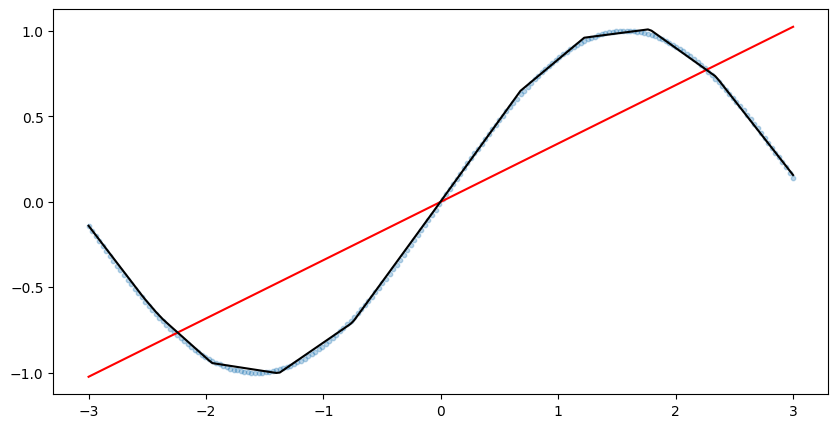

In [45]:
# 시각화
plt.figure(figsize=(10, 5))

# 원본 데이터 산점도 그래프
plt.scatter(x, y, s=10, alpha=0.3, label='Original Data')
# 선형 모델 예측 결과 - 라인 그래프
plt.plot(x, linear_pred, 'r-')
# 비선형 모델 예측 결과 - 라인 그래프
plt.plot(x, relu_pred, 'k-')

plt.show()